# Summary of filters

Families:
* Remove 11299, outlier with 893 total denovos

In [1]:
%pylab inline

import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls/"

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


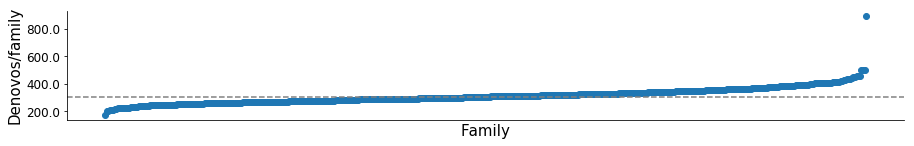

In [3]:
# Plot by family
byfamily = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_byfamily.tab"), sep="\t", names=["family","denovos"])

fig = plt.figure()
fig.set_size_inches((15, 2))
ax = fig.add_subplot(111)
byfamily = byfamily.sort("denovos")
ax.scatter(range(byfamily.shape[0]), byfamily["denovos"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_xticks(range(byfamily.shape[0]))
#ax.set_xticklabels(byfamily["family"], rotation=90, size=8);
ax.set_xlabel("Family", size=15)
ax.set_xticks([])
ax.set_ylabel("Denovos/family", size=15)
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.axhline(np.median(byfamily["denovos"]), linestyle="dashed", color="gray");

In [4]:
# Plot by child for each family
bychild = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild.tab"), sep="\t", names=["family","child","status","denovos"])
unaffected = []
affected = []
for family in byfamily["family"]:
    u = bychild[(bychild["family"]==family) & (bychild["status"]==1)]["denovos"].values[0]
    a = bychild[(bychild["family"]==family) & (bychild["status"]==2)]["denovos"].values[0]
    unaffected.append(u)
    affected.append(a)
byfamily["unaffected"] = unaffected
byfamily["affected"] = affected

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


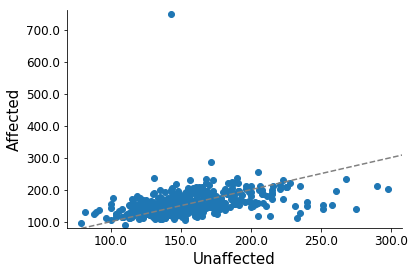

In [10]:
byfamily = byfamily.sort("denovos")
buf = 10
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(byfamily["unaffected"], byfamily["affected"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel("Unaffected", size=15)
ax.set_ylabel("Affected", size=15)
minval=min(list(byfamily["affected"])+list(byfamily["unaffected"]))
maxval=max(list(byfamily["affected"])+list(byfamily["unaffected"]))
ax.plot([minval, maxval],[minval,maxval], color="gray", linestyle="dashed")
ax.set_xlim(left=min(byfamily["unaffected"])-buf, right=max(byfamily["unaffected"])+buf)
ax.set_ylim(bottom=min(byfamily["affected"])-buf, top=max(byfamily["affected"])+buf)
ax.set_xticklabels(ax.get_xticks(), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);

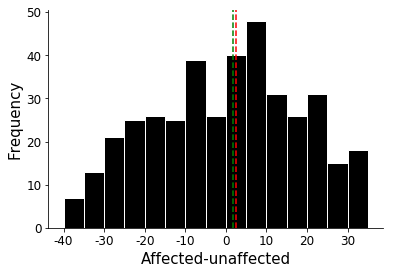

In [13]:
# Histogram of diff in affected-unaffected
fig = plt.figure()
ax = fig.add_subplot(111)
diff = byfamily["affected"]-byfamily["unaffected"]
ax.hist(diff,
        bins = np.arange(-40, 40, 5),
        color="black", edgecolor="white");
ax.set_xlabel("Affected-unaffected", size=15);
ax.set_ylabel("Frequency", size=15);
ax.set_xticklabels(map(lambda x: int(x), ax.get_xticks()), size=12);
ax.set_yticklabels(map(lambda x: int(x), ax.get_yticks()), size=12);
ax.axvline(np.median(diff), color="red", linestyle="dashed")
ax.axvline(np.mean(diff), color="green", linestyle="dashed")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#print np.median(diff), np.mean(diff)

In [17]:
# Ask if status affects num denovos - paired by family
scipy.stats.ttest_1samp(byfamily["affected"]-byfamily["unaffected"], popmean=0)

Ttest_1sampResult(statistic=0.97123725723212329, pvalue=0.33192444693145484)

In [18]:
# Ask if status affects num denovos - overall
scipy.stats.ks_2samp(byfamily["affected"],byfamily["unaffected"])

Ks_2sampResult(statistic=0.042016806722689037, pvalue=0.78650132873808232)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(0, 460)

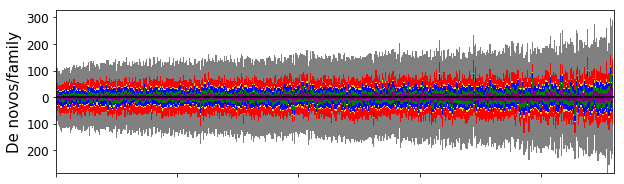

In [42]:
# Plot by period for each family
byfamily = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_byfamily.tab"), sep="\t", names=["family","denovos"])

res_a = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_byfamily_byperiod_affected.tab"), sep="\t",
                 names=["family","period","denovo"])
res_ua = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_byfamily_byperiod_unaffected.tab"), sep="\t",
                 names=["family","period","denovo"])
for period in range(1, 7):
    tmp = res_a[res_a["period"]==period]
    tmp["period%s-a"%period] = tmp["denovo"]
    byfamily = pd.merge(byfamily, tmp[["family","period%s-a"%period]], on="family")
    tmp = res_ua[res_ua["period"]==period]
    tmp["period%s-ua"%period] = tmp["denovo"]
    byfamily = pd.merge(byfamily, tmp[["family","period%s-ua"%period]], on="family")
byfamily = byfamily.sort("denovos")
byfamily = byfamily[byfamily["family"]!=11299]
xvals = range(byfamily.shape[0])
byfamily["yval-ua"] = 0
byfamily["yval-a"] = 0
fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(111)
colors = ["gray","red","gold","blue","green","purple"]
for period in [6,5,4,3,2,1]:
    percolor = colors[period-1]
    ax.bar(xvals, byfamily["period%s-ua"%period], bottom=byfamily["yval-ua"], color=percolor, width=1)
    byfamily["yval-ua"] = byfamily["yval-ua"] + byfamily["period%s-ua"%period]
    ax.bar(xvals, -1*(byfamily["period%s-a"%period]), bottom=(-1*byfamily["yval-a"]), color=percolor, width=1)
    byfamily["yval-a"] = byfamily["yval-a"] + byfamily["period%s-a"%period]
ax.axhline(y=0, color="black")
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("De novos/family", size=15)
ax.set_yticklabels([int(abs(item)) for item in ax.get_yticks()], size=12);
ax.set_xlim(left=0, right=byfamily.shape[0])